# Importing the required libraries

In [1]:
import numpy as np
import pandas as pd
import pickle
import cv2
import sys
import keras
import tensorflow as tf

from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.metrics import categorical_accuracy
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.preprocessing import image
from keras_preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
print(f"Python version: {sys.version}")
print(f"Tensorflow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")
print(f"OpenCV version: {cv2.__version__}")

Python version: 3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:53) 
[GCC 9.4.0]
Tensorflow version: 2.9.2
Keras version: 2.9.0
OpenCV version: 4.5.4


In [3]:
tf.test.is_gpu_available()

True

In [4]:
EPOCHS = 50
INIT_LR = 1e-3 # 1E-3
BS = 32
width=128
height=128
default_image_size = tuple((height,width))
image_size = 0
directory_root = '/kaggle/input/plantdisease'
depth=3

We defined a function to convert image to a Numpy array.

In [5]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [6]:
def load_image_from_dir(start=0, end=500, image_list=[], label_list=[]):
    try:
        print("Loading images ...")
        root_dir = listdir(directory_root)
        for directory in root_dir :
            # remove .DS_Store from list
            if directory == ".DS_Store" :
                root_dir.remove(directory)

        for plant_folder in root_dir :
            plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")

            for disease_folder in plant_disease_folder_list :
                # remove .DS_Store from list
                if disease_folder == ".DS_Store" :
                    plant_disease_folder_list.remove(disease_folder)

            for plant_disease_folder in plant_disease_folder_list:
                print(f"\t*Processing {plant_disease_folder} ...")
                plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}")

                for single_plant_disease_image in plant_disease_image_list :
                    if single_plant_disease_image == ".DS_Store" :
                        plant_disease_image_list.remove(single_plant_disease_image)
                if start > len(plant_disease_image_list):
                    for image in plant_disease_image_list[0:100]:
                        image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                        if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                            image_list.append(convert_image_to_array(image_directory))
                            label_list.append(plant_disease_folder)
                else:
                    for image in plant_disease_image_list[start:end]:
                        image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                        if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                            image_list.append(convert_image_to_array(image_directory))
                            label_list.append(plant_disease_folder)
        print("Image loading completed")  
    except Exception as e:
        print(f"Error : {e}")
    finally:
        return image_list, label_list

In [7]:
image_list, label_list = [], []
image_list, label_list = load_image_from_dir(
    start=0, 
    end=500, 
    image_list=image_list, 
    label_list=label_list
)

Loading images ...
	*Processing Pepper__bell___Bacterial_spot ...
	*Processing Potato___healthy ...
	*Processing Tomato_Leaf_Mold ...
	*Processing Tomato__Tomato_YellowLeaf__Curl_Virus ...
	*Processing Tomato_Bacterial_spot ...
	*Processing Tomato_Septoria_leaf_spot ...
	*Processing Tomato_healthy ...
	*Processing Tomato_Spider_mites_Two_spotted_spider_mite ...
	*Processing Tomato_Early_blight ...
	*Processing Tomato__Target_Spot ...
	*Processing Pepper__bell___healthy ...
	*Processing Potato___Late_blight ...
	*Processing Tomato_Late_blight ...
	*Processing Potato___Early_blight ...
	*Processing Tomato__Tomato_mosaic_virus ...
	*Processing PlantVillage ...
Image loading completed


In [8]:
# Get size of processed image
image_size = len(image_list)
print(image_size)

7025


In [9]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

print(label_binarizer.classes_)

['Pepper__bell___Bacterial_spot' 'Pepper__bell___healthy'
 'Potato___Early_blight' 'Potato___Late_blight' 'Potato___healthy'
 'Tomato_Bacterial_spot' 'Tomato_Early_blight' 'Tomato_Late_blight'
 'Tomato_Leaf_Mold' 'Tomato_Septoria_leaf_spot'
 'Tomato_Spider_mites_Two_spotted_spider_mite' 'Tomato__Target_Spot'
 'Tomato__Tomato_YellowLeaf__Curl_Virus' 'Tomato__Tomato_mosaic_virus'
 'Tomato_healthy']


In [10]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0

In [11]:
print("Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(
    np_image_list, 
    image_labels, 
    test_size=0.2, 
    random_state=42
#     stratify=image_labels
) 

Spliting data to train, test


In [12]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((5620, 128, 128, 3), (5620, 15), (1405, 128, 128, 3), (1405, 15))

In [13]:
aug = ImageDataGenerator(
    rotation_range=45,          # Randomly rotates images in range [-45, 45] degrees
    width_shift_range=0.1,
    height_shift_range=0.1, 
    shear_range=0.2, 
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest"         # fill newly created missing pixels during the image transformation
)

In [14]:
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

In [15]:
# Get model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 activation (Activation)     (None, 128, 128, 32)      0         
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 42, 42, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 42, 42, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 42, 64)        1

In [16]:
#Compiling Model
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)

model.compile(
    loss="categorical_crossentropy", 
    optimizer=opt,
    metrics=["accuracy"]
)

In [17]:
#Fitting Model
checkpoint_config = ModelCheckpoint('best_model.h5', 
                                    monitor='val_loss',
                                    verbose=1,
                                    save_best_only=True, 
                                    mode='auto')

history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, 
    verbose=1,
    callbacks=[checkpoint_config]
)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/50
175/175 [==============================] - ETA: 0s - loss: 1.7104 - accuracy: 0.5091
Epoch 1: val_loss improved from inf to 15.59138, saving model to best_model.h5
175/175 [==============================] - 28s 128ms/step - loss: 1.7104 - accuracy: 0.5091 - val_loss: 15.5914 - val_accuracy: 0.0705
Epoch 2/50
175/175 [==============================] - ETA: 0s - loss: 1.2174 - accuracy: 0.6253
Epoch 2: val_loss did not improve from 15.59138
175/175 [==============================] - 21s 119ms/step - loss: 1.2174 - accuracy: 0.6253 - val_loss: 18.5983 - val_accuracy: 0.0968
Epoch 3/50
175/175 [==============================] - ETA: 0s - loss: 0.9695 - accuracy: 0.6899
Epoch 3: val_loss improved from 15.59138 to 7.31039, saving model to best_model.h5
175/175 [==============================] - 21s 119ms/step - loss: 0.9695 - accuracy: 0.6899 - val_loss: 7.3104 - val_accuracy: 0.2192
Epoch 4/50
175/175 [==============================] - ETA: 0s - loss: 0.9032 - accuracy: 0.7135
Ep

# Calculate model accuracy

In [18]:
test_model = keras.models.load_model('best_model.h5')
scores = test_model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

44/44 [==============================] - 1s 8ms/step - loss: 0.3560 - accuracy: 0.8911
Test Accuracy: 89.1103208065033


# Predict from new data

In [23]:
def load_test_image_from_dir(start=0, end=500, image_list=[], label_list=[]):
    try:
        print("Loading images ...")
        root_dir = listdir(directory_root)
        for directory in root_dir :
            # remove .DS_Store from list
            if directory == ".DS_Store" :
                root_dir.remove(directory)

        for plant_folder in root_dir :
            plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")

            for disease_folder in plant_disease_folder_list :
                # remove .DS_Store from list
                if disease_folder == ".DS_Store" :
                    plant_disease_folder_list.remove(disease_folder)

            for plant_disease_folder in plant_disease_folder_list:
                print(f"\t*Processing {plant_disease_folder} ...")
                plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}")

                for single_plant_disease_image in plant_disease_image_list :
                    if single_plant_disease_image == ".DS_Store" :
                        plant_disease_image_list.remove(single_plant_disease_image)
                if start > len(plant_disease_image_list):
                    for image in plant_disease_image_list[0:100]:
                        image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                        if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                            image_list.append(image_directory)
                            label_list.append(plant_disease_folder)
                else:
                    for image in plant_disease_image_list[start:end]:
                        image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                        if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                            image_list.append(image_directory)
                            label_list.append(plant_disease_folder)
        print("Image loading completed")  
    except Exception as e:
        print(f"Error : {e}")
    finally:
        return image_list, label_list

In [24]:
test_image_list, test_label_list = [], []
test_image_list, test_label_list = load_test_image_from_dir(
    start=500, 
    end=600, 
    image_list=test_image_list, 
    label_list=test_label_list
)

Loading images ...
	*Processing Pepper__bell___Bacterial_spot ...
	*Processing Potato___healthy ...
	*Processing Tomato_Leaf_Mold ...
	*Processing Tomato__Tomato_YellowLeaf__Curl_Virus ...
	*Processing Tomato_Bacterial_spot ...
	*Processing Tomato_Septoria_leaf_spot ...
	*Processing Tomato_healthy ...
	*Processing Tomato_Spider_mites_Two_spotted_spider_mite ...
	*Processing Tomato_Early_blight ...
	*Processing Tomato__Target_Spot ...
	*Processing Pepper__bell___healthy ...
	*Processing Potato___Late_blight ...
	*Processing Tomato_Late_blight ...
	*Processing Potato___Early_blight ...
	*Processing Tomato__Tomato_mosaic_virus ...
	*Processing PlantVillage ...
Image loading completed


In [37]:
CATEGORIES = ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy',
 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy',
 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight',
 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

def image_to_array(path):
    img = cv2.imread(path)
    new_arr = cv2.resize(img,(128, 128))
    new_arr = np.array(new_arr/255)
    new_arr = new_arr.reshape(-1, 128, 128, 3)
    return new_arr


In [38]:
actual = {_key: 0 for _key in test_label_list}
predicted = {_key: 0 for _key in test_label_list}

for i in range(len(test_image_list)):
    image = image_to_array(test_image_list[i])
    prediction = test_model.predict(image, verbose=0)
    
    actual[test_label_list[i]] += 1
    predicted[CATEGORIES[prediction.argmax()]] += 1
#     print(f"Act: {test_label_list[i]}, pred: {CATEGORIES[prediction.argmax()]}")


    
print(actual)
print(predicted)

{'Pepper__bell___Bacterial_spot': 100, 'Potato___healthy': 100, 'Tomato_Leaf_Mold': 100, 'Tomato__Tomato_YellowLeaf__Curl_Virus': 100, 'Tomato_Bacterial_spot': 100, 'Tomato_Septoria_leaf_spot': 100, 'Tomato_healthy': 100, 'Tomato_Spider_mites_Two_spotted_spider_mite': 100, 'Tomato_Early_blight': 100, 'Tomato__Target_Spot': 100, 'Pepper__bell___healthy': 100, 'Potato___Late_blight': 100, 'Tomato_Late_blight': 100, 'Potato___Early_blight': 100, 'Tomato__Tomato_mosaic_virus': 100}
{'Pepper__bell___Bacterial_spot': 96, 'Potato___healthy': 101, 'Tomato_Leaf_Mold': 89, 'Tomato__Tomato_YellowLeaf__Curl_Virus': 101, 'Tomato_Bacterial_spot': 106, 'Tomato_Septoria_leaf_spot': 103, 'Tomato_healthy': 115, 'Tomato_Spider_mites_Two_spotted_spider_mite': 92, 'Tomato_Early_blight': 107, 'Tomato__Target_Spot': 107, 'Pepper__bell___healthy': 93, 'Potato___Late_blight': 104, 'Tomato_Late_blight': 72, 'Potato___Early_blight': 109, 'Tomato__Tomato_mosaic_virus': 105}


In [39]:
actual_labels = []
predicted_labels = []

for label, count in actual.items():
    actual_labels.extend([label] * count)
for label, count in predicted.items():
    predicted_labels.extend([label] * count)

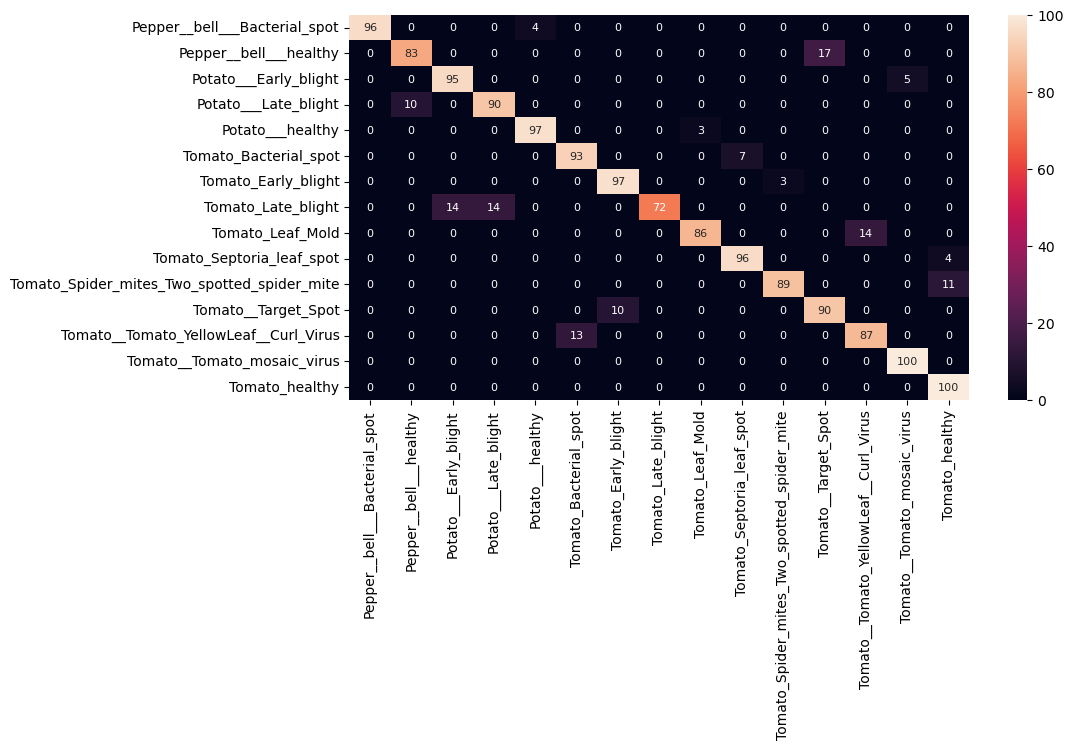

In [42]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(actual_labels, predicted_labels, labels=CATEGORIES)
cm_df = pd.DataFrame(cm, index=CATEGORIES, columns=CATEGORIES)

plt.figure(figsize = (10,5))
sns.heatmap(cm_df, annot=True, annot_kws={"size": 8}, fmt="")
plt.show()

In [43]:
from sklearn.metrics import classification_report

report = classification_report(actual_labels, predicted_labels)

print(f'Classification report: \n{report}')

Classification report: 
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       1.00      0.96      0.98       100
                     Pepper__bell___healthy       0.89      0.83      0.86       100
                      Potato___Early_blight       0.87      0.95      0.91       100
                       Potato___Late_blight       0.87      0.90      0.88       100
                           Potato___healthy       0.96      0.97      0.97       100
                      Tomato_Bacterial_spot       0.88      0.93      0.90       100
                        Tomato_Early_blight       0.91      0.97      0.94       100
                         Tomato_Late_blight       1.00      0.72      0.84       100
                           Tomato_Leaf_Mold       0.97      0.86      0.91       100
                  Tomato_Septoria_leaf_spot       0.93      0.96      0.95       100
Tomato_Spider_mites_Two_spotted_spider_m